A continuación serealizará un modelo de ensamblado especialmente diseñado para el problema de riesgo crediticio con fuerte desbalance (8 % de positivos).

El flujo de trabajo paso a paso incluye:

1. Preprocesamiento (imputación, escalado, codificación).

2. Técnicas de balanceo (SMOTE, ADASYN, BorderlineSMOTE, SMOTEENN, SMOTETomek, RandomUnderSampler, class_weight).

3. Selección de estimadores base (RandomForest, XGBoost, LogisticRegression).

4. GridSearchCV amplio con validación cruzada estratificada.

5. Ensamble por apilamiento (StackingClassifier) con meta-estimador.

6. Evaluación básica (matriz de confusión, classification report, AUC-ROC, PR curve).

7. Evaluación avanzada (curva de calibración, lift chart, KS statistic, feature importance/SHAP).




# Sección 1: Configuración Inicial y Preparación de Datos

## 1. Carga y división de datos

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Carga
df = pd.read_csv(r"C:\Users\DELL\Desktop\Aprendizaje_de_Maquina\credit_risk_the_end.csv")
X = df.drop("incumplimiento_credito", axis=1)
y = df["incumplimiento_credito"]

# 2. División
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## 2. Preprocesamiento

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Detectar columnas
num_cols = X.select_dtypes(include=["int64","float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])


## 3. Definición de técnicas de balanceo

In [3]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

sampler_dict = {
    "SMOTE":        SMOTE(random_state=42),
    "ADASYN":       ADASYN(random_state=42),
    "Borderline":   BorderlineSMOTE(random_state=42),
    "SMOTEENN":     SMOTEENN(random_state=42),
    "SMOTETomek":   SMOTETomek(random_state=42),
    "UnderSampler": RandomUnderSampler(random_state=42),
}

samplers = list(sampler_dict.values())


## 4. Estimadores base

Se probarán tres familias de modelos:

* RandomForestClassifier (con class_weight='balanced').

* XGBClassifier (con scale_pos_weight ajustado).

* LogisticRegression (con class_weight='balanced').

In [4]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

estimators = {
    "RF": RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
    "XGB": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"),
    "LR": LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced")
}

# Sección 2: Fase de Modelado

## 1. Grid para RandomForest

In [5]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time

pipeline_rf = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", samplers[0]),  # placeholder, se selecciona en la grilla
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid_rf = {
    "sampler": samplers,
    "clf__n_estimators": [100],
    "clf__max_depth": [None, 10],
    "clf__min_samples_split": [2, 5]
}

# Definir el esquema de validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_rf = GridSearchCV(
    pipeline_rf,
    param_grid_rf,
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Medir tiempo de entrenamiento después de definir grid_rf
t0 = time.time()
grid_rf.fit(X_train, y_train)
t_rf = time.time() - t0

# Mostrar visualmente el mejor estimador
grid_rf.best_estimator_
best_rf = grid_rf.best_estimator_
print(best_rf)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['tipo_contrato', 'genero', 'posee_auto', 'posee_vivienda',
       'ingreso_total', 'cuota_periodica', 'poblacion_relativa_region',
       'dias_desde_nacimiento', 'dias_desde_registro', 'dias_desde_emision_id'...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['numero_hijos', 'acompanantes_solicitud', 'tipo_ingreso',
       'nivel

## 2.Grid para XGBoost

In [6]:
from xgboost                   import XGBClassifier
import time

pipeline_xgb = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", samplers[0]),
    ("clf", XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    ))
])

param_grid_xgb = {
    "sampler": samplers,
    "clf__n_estimators":     [100],
    "clf__max_depth":        [3, 5, 7],
    "clf__learning_rate":    [0.05, 0.1],
    "clf__scale_pos_weight": [1, 5, 10]
}

# Definir el esquema de validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Medir tiempo de entrenamiento después de definir grid_rf
t0 = time.time()
grid_xgb.fit(X_train, y_train)
t_xgb = time.time() - t0

from sklearn import set_config
set_config(display='diagram')  # Activa el modo de diagrama

# Mostrar visualmente el mejor estimador
grid_xgb.best_estimator_
best_xgb = grid_xgb.best_estimator_
print(best_xgb)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['tipo_contrato', 'genero', 'posee_auto', 'posee_vivienda',
       'ingreso_total', 'cuota_periodica', 'poblacion_relativa_region',
       'dias_desde_nacimiento', 'dias_desde_registro', 'dias_desde_emision_id'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                      

c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\xgboost\core.py:158: UserWarning: [14:05:20] WARNING: D:\bld\xgboost-split_1744329010901\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## 3.Grid para LogisticRegression

In [7]:
from sklearn.linear_model     import LogisticRegression
import time

pipeline_lr = ImbPipeline([
    ("preproc", preprocessor),
    ("sampler", samplers[0]),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="liblinear"
    ))
])

param_grid_lr = {
    "sampler": samplers,
    "clf__C":       [0.001, 0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"]
}

# Definir el esquema de validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lr = GridSearchCV(
    pipeline_lr,
    param_grid_lr,
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

t0 = time.time()
grid_lr.fit(X_train, y_train)
t_lr = time.time() - t0

# Mostrar visualmente el mejor estimador
grid_lr.best_estimator_
best_lr = grid_lr.best_estimator_
print(best_lr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['tipo_contrato', 'genero', 'posee_auto', 'posee_vivienda',
       'ingreso_total', 'cuota_periodica', 'poblacion_relativa_region',
       'dias_desde_nacimiento', 'dias_desde_registro', 'dias_desde_emision_id'...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['numero_hijos', 'acompanantes_solicitud', 'tipo_ingreso',
       'nivel

## 4.Recuperar los mejores estimadores

In [8]:
best_rf = grid_rf.best_estimator_
best_xgb = grid_xgb.best_estimator_
best_lr = grid_lr.best_estimator_


## 5.Ensamble por apilamiento (Stacking)

In [9]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Definir el modelo de stacking
stack = StackingClassifier(
    estimators=[
        ("RF", best_rf),   # ya incluye preproc + sampler
        ("XGB", best_xgb),
        ("LR", best_lr),
    ],
    final_estimator=LogisticRegression(class_weight="balanced", random_state=42),
    cv=cv,
    n_jobs=-1,
    passthrough=False
)

# Medir tiempo de entrenamiento (después de definir `stack`)
import time
t0 = time.time()
stack.fit(X_train, y_train)
t_stack = time.time() - t0

# Sección 3: Evaluación Básica del Modelo

## 1.Métricas de Desempeño

In [10]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import pandas as pd

# Modelos + tiempos
models = {
    "RF":    best_rf,
    "XGB":   best_xgb,
    "LR":    best_lr,
    "STACK": stack if "stack" in globals() else stack_pipeline
}

opt_times = {
    "RF":    t_rf,
    "XGB":   t_xgb,
    "LR":    t_lr,
    "STACK": t_stack
}

records = []
for name, mdl in models.items():
    y_pred  = mdl.predict(X_test)
    y_proba = mdl.predict_proba(X_test)[:,1]

    records.append({
        "Modelo":             name,
        "Precision":          precision_score(y_test, y_pred, zero_division=0),
        "Recall":             recall_score(y_test, y_pred, zero_division=0),
        "F1-score":           f1_score(y_test, y_pred, zero_division=0),
        "AUC-ROC":            roc_auc_score(y_test, y_proba),
        "Avg Precision":      average_precision_score(y_test, y_proba),
        "Tiempo Optimización (s)": round(opt_times[name], 1)
    })

df_metrics = pd.DataFrame(records).set_index("Modelo").round(4)
df_metrics["Rank Recall"] = df_metrics["Recall"].rank(ascending=False).astype(int)

best_model = df_metrics["Recall"].idxmax()

# Mostrar con estilo
display(
    df_metrics.style
      .background_gradient(subset=["Recall","AUC-ROC","Avg Precision"], cmap="Blues")
      .highlight_max("Recall", color="salmon")
      .set_caption("Comparativa de métricas y tiempos de optimización")
)
print(f"➡️ Mejor modelo por Recall: {best_model}")


,Precision,Recall,F1-score,AUC-ROC,Avg Precision,Tiempo Optimización (s),Rank Recall
Modelo,,,,,,,
RF,0.163000,0.660700,0.261500,0.736000,0.220800,350.900000,4
XGB,0.085800,1.000000,0.158100,0.738100,0.227800,1213.200000,1
LR,0.152700,0.721800,0.252100,0.741000,0.224300,367.500000,2
STACK,0.165000,0.685300,0.265900,0.744200,0.228100,120.300000,3


➡️ Mejor modelo por Recall: XGB


## 2.Tiempo de Entrenamiento

In [11]:
t_rf    # segundos que tardó grid_rf.fit(...)
t_xgb   # segundos que tardó grid_xgb.fit(...)
t_lr    # segundos que tardó grid_lr.fit(...)
t_stack # segundos que tardó stack.fit(...)


120.26613926887512

In [12]:
print("t_rf   :", 't_rf'   in globals())
print("t_xgb  :", 't_xgb'  in globals())
print("t_lr   :", 't_lr'   in globals())
print("t_stack:", 't_stack' in globals())


t_rf   : True
t_xgb  : True
t_lr   : True
t_stack: True


In [13]:
models = {                     # todos entrenados
    "RF"   : best_rf,
    "XGB"  : best_xgb,
    "LR"   : best_lr,
    "Stack": stack
}
X_test, y_test                 # tu partición hold‑out
t_rf, t_xgb, t_lr, t_stack     # tiempos de entrenamiento en segundos


(350.88095355033875, 1213.2059261798859, 367.4862518310547, 120.26613926887512)

C:\Users\DELL\AppData\Local\Temp\ipykernel_45596\1458496527.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("Pastel1").colors   # tuple de 9 colores


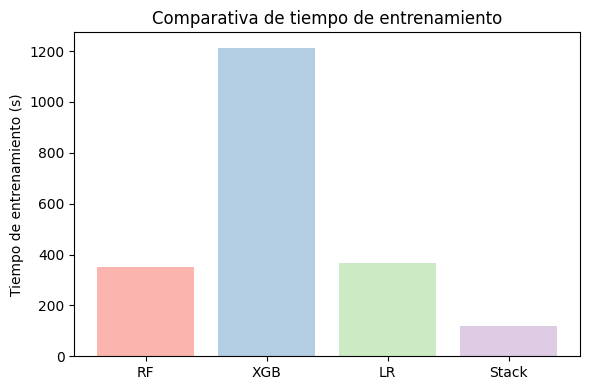

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm            # 👈 import correcto para get_cmap
# alternativa moderna: from matplotlib import colormaps as cm

# Diccionario con los tiempos (segundos)
times = {"RF": t_rf, "XGB": t_xgb, "LR": t_lr, "Stack": t_stack}

# Paleta Pastel1
colors = cm.get_cmap("Pastel1").colors   # tuple de 9 colores

plt.figure(figsize=(6, 4))
plt.bar(times.keys(), times.values(), color=colors[:len(times)])
plt.ylabel("Tiempo de entrenamiento (s)")
plt.title("Comparativa de tiempo de entrenamiento")
plt.tight_layout()
plt.show()


## 3.Curvas ROC

C:\Users\DELL\AppData\Local\Temp\ipykernel_45596\4266705713.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = get_cmap("Pastel1")


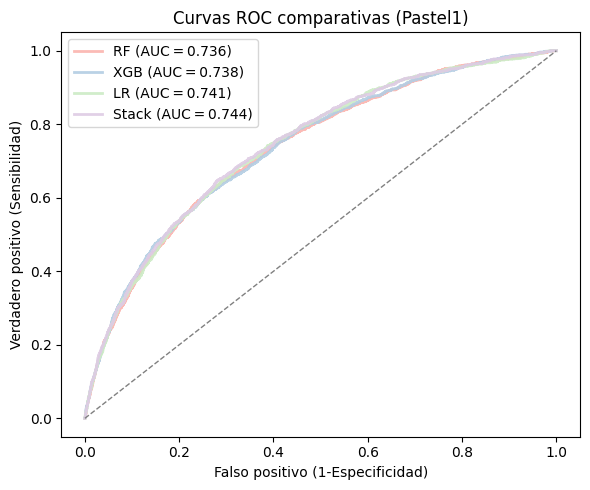

In [15]:
# CHUNK ─ Todas las curvas ROC en una sola gráfica
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.metrics import roc_curve, auc

# paleta Pastel1
cmap   = get_cmap("Pastel1")
colors = [cmap(i) for i in range(len(models))]

plt.figure(figsize=(6, 5))

for (name, mdl), color in zip(models.items(), colors):
    y_proba = mdl.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc     = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})",
             color=color, lw=2, alpha=0.9)

# diagonal aleatoria
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", lw=1)

plt.title("Curvas ROC comparativas (Pastel1)")
plt.xlabel("Falso positivo (1‑Especificidad)")
plt.ylabel("Verdadero positivo (Sensibilidad)")
plt.legend()
plt.tight_layout()
plt.show()


## 4.Matrices de Confusión

C:\Users\DELL\AppData\Local\Temp\ipykernel_45596\676654867.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = get_cmap("Pastel1")


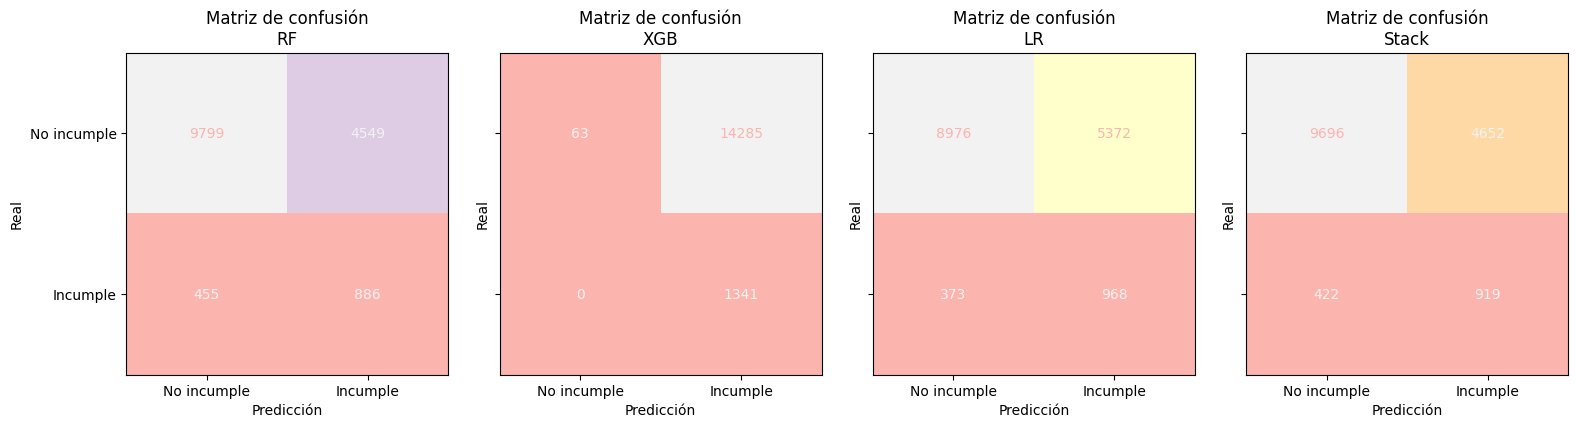

In [16]:

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

n_models = len(models)
cols     = n_models               # una fila, una columna por modelo
fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 4), sharey=True)

# Paleta Pastel1
cmap   = get_cmap("Pastel1")
colors = [cmap(i) for i in range(n_models)]

for ax, (name, mdl), color in zip(axes, models.items(), colors):
    y_pred = mdl.predict(X_test)
    cm     = confusion_matrix(y_test, y_pred)
    disp   = ConfusionMatrixDisplay(cm, display_labels=["No incumple", "Incumple"])
    disp.plot(ax=ax, cmap="Pastel1", colorbar=False)   # ← usa paleta Pastel1
    ax.set_title(f"Matriz de confusión\n{name}")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.show()


## 5.Curvas Precision-Recall

C:\Users\DELL\AppData\Local\Temp\ipykernel_45596\2143545684.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = get_cmap("Pastel1")


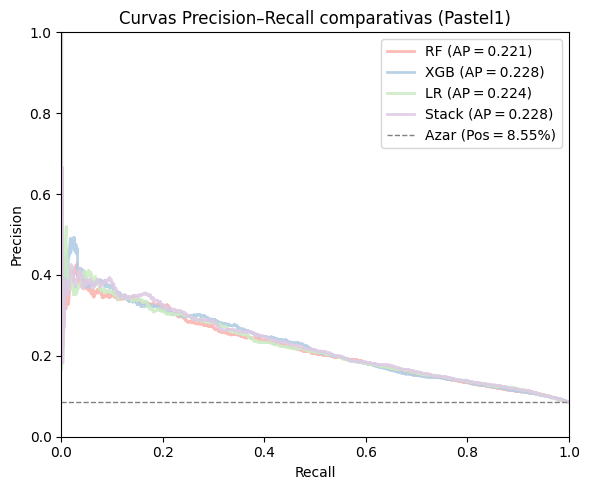

In [17]:

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.metrics import precision_recall_curve, average_precision_score

# paleta Pastel1
cmap   = get_cmap("Pastel1")
colors = [cmap(i) for i in range(len(models))]

plt.figure(figsize=(6, 5))

for (name, mdl), color in zip(models.items(), colors):
    y_proba = mdl.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision,
             label=f"{name} (AP = {ap:.3f})",
             color=color, lw=2, alpha=0.9)

# línea horizontal de referencia (prevalencia positiva)
baseline = y_test.mean()
plt.hlines(baseline, 0, 1, colors="gray", linestyles="--", lw=1,
           label=f"Azar (Pos = {baseline:.2%})")

plt.title("Curvas Precision–Recall comparativas (Pastel1)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.tight_layout()
plt.show()


## 6. Lift Chart

C:\Users\DELL\AppData\Local\Temp\ipykernel_45596\2969561580.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = get_cmap("Pastel1"); colors = [cmap(i) for i in range(len(models))]


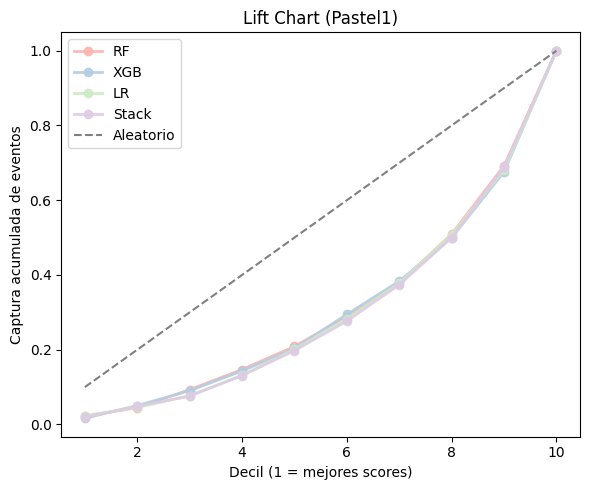

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

def lift_table(y_true, scores, deciles=10):
    df = pd.DataFrame({"y": y_true, "score": scores})
    df = df.sort_values("score", ascending=False).reset_index(drop=True)
    df["decil"] = pd.qcut(df.index, deciles, labels=False)
    tab = (df.groupby("decil")
             .agg(events=("y", "sum"), total=("y","size"))
             .sort_index(ascending=False))
    tab["capture"] = tab["events"].cumsum() / tab["events"].sum()
    return tab["capture"].values

cmap   = get_cmap("Pastel1"); colors = [cmap(i) for i in range(len(models))]
plt.figure(figsize=(6,5))
for (name, mdl), color in zip(models.items(), colors):
    capture = lift_table(y_test, mdl.predict_proba(X_test)[:,1])
    plt.plot(range(1,11), capture, marker="o", label=name,
             color=color, lw=2, alpha=0.9)

plt.plot(range(1,11), [i/10 for i in range(1,11)], "--", color="gray",
         label="Aleatorio")
plt.xlabel("Decil (1 = mejores scores)")
plt.ylabel("Captura acumulada de eventos")
plt.title("Lift Chart (Pastel1)")
plt.legend(); plt.tight_layout(); plt.show()


## 7.KS Statistic por modelo

C:\Users\DELL\AppData\Local\Temp\ipykernel_45596\3582317977.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.bar(ks_vals.keys(), ks_vals.values(), color=get_cmap("Pastel1").colors)


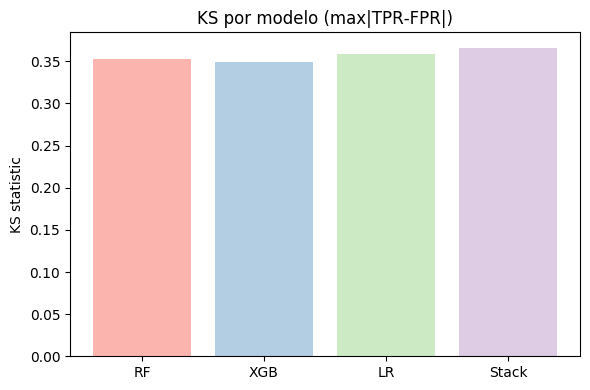

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from sklearn.metrics import roc_curve

ks_vals = {}
for name, mdl in models.items():
    fpr, tpr, _ = roc_curve(y_test, mdl.predict_proba(X_test)[:,1])
    ks_vals[name] = np.max(np.abs(tpr - fpr))

plt.figure(figsize=(6,4))
plt.bar(ks_vals.keys(), ks_vals.values(), color=get_cmap("Pastel1").colors)
plt.ylabel("KS statistic")
plt.title("KS por modelo (max|TPR‑FPR|)")
plt.tight_layout(); plt.show()


## 8.Curvas de Calibracion

C:\Users\DELL\AppData\Local\Temp\ipykernel_45596\926752222.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap   = cm.get_cmap("Pastel1")                # OK con Matplotlib ≥ 3.7


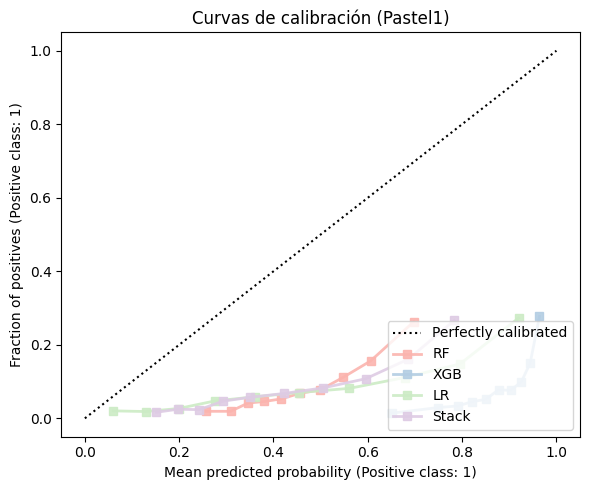

In [20]:
# CHUNK — Curvas de calibración comparativas
import matplotlib.pyplot as plt
from matplotlib import cm                       # ← alternativa moderna a get_cmap
from sklearn.calibration import CalibrationDisplay

cmap   = cm.get_cmap("Pastel1")                # OK con Matplotlib ≥ 3.7
colors = [cmap(i) for i in range(len(models))]

fig, ax = plt.subplots(figsize=(6, 5))

for (name, mdl), color in zip(models.items(), colors):
    CalibrationDisplay.from_predictions(
        y_test,
        mdl.predict_proba(X_test)[:, 1],
        n_bins=10,
        strategy="quantile",
        name=name,
        ax=ax,                                 # todas las curvas en el mismo eje
        color=color,
        linewidth=2,
        alpha=0.9,
    )

ax.set_title("Curvas de calibración (Pastel1)")
plt.tight_layout()
plt.show()


## 9.KS Statistic

In [21]:
from scipy.stats import ks_2samp
pos = y_proba[y_test==1]
neg = y_proba[y_test==0]
ks_stat, _ = ks_2samp(pos, neg)
print("KS:", ks_stat)


KS: 0.3661449280243284


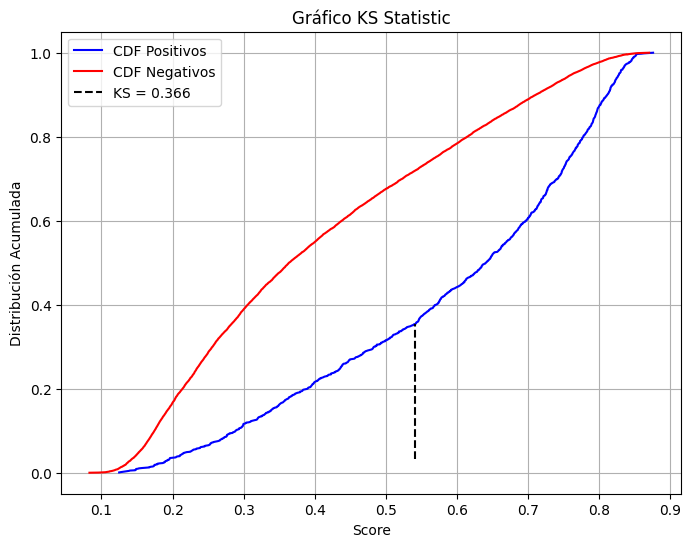

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp

# Scores
pos = y_proba[y_test == 1]
neg = y_proba[y_test == 0]

# CDFs
pos_sorted = np.sort(pos)
neg_sorted = np.sort(neg)
cdf_pos = np.arange(1, len(pos_sorted)+1) / len(pos_sorted)
cdf_neg = np.arange(1, len(neg_sorted)+1) / len(neg_sorted)

# Calcular KS statistic
ks_stat, _ = ks_2samp(pos, neg)
ks_position = np.argmax(np.abs(np.interp(pos_sorted, neg_sorted, cdf_neg) - cdf_pos))

# Plot KS
plt.figure(figsize=(8, 6))
plt.plot(pos_sorted, cdf_pos, label="CDF Positivos", color="blue")
plt.plot(neg_sorted, cdf_neg, label="CDF Negativos", color="red")
plt.vlines(pos_sorted[ks_position], cdf_neg[ks_position], cdf_pos[ks_position], color="black", linestyle="--", label=f"KS = {ks_stat:.3f}")
plt.xlabel("Score")
plt.ylabel("Distribución Acumulada")
plt.title("Gráfico KS Statistic")
plt.legend()
plt.grid(True)
plt.show()


## 10.Feature importance y SHAP

In [23]:
import os
os.environ["SHAP_FORCE_LOAD"] = "1"   # evita carga de librerías GPU
import shap


c:\Users\DELL\anaconda3\envs\KrakenData\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


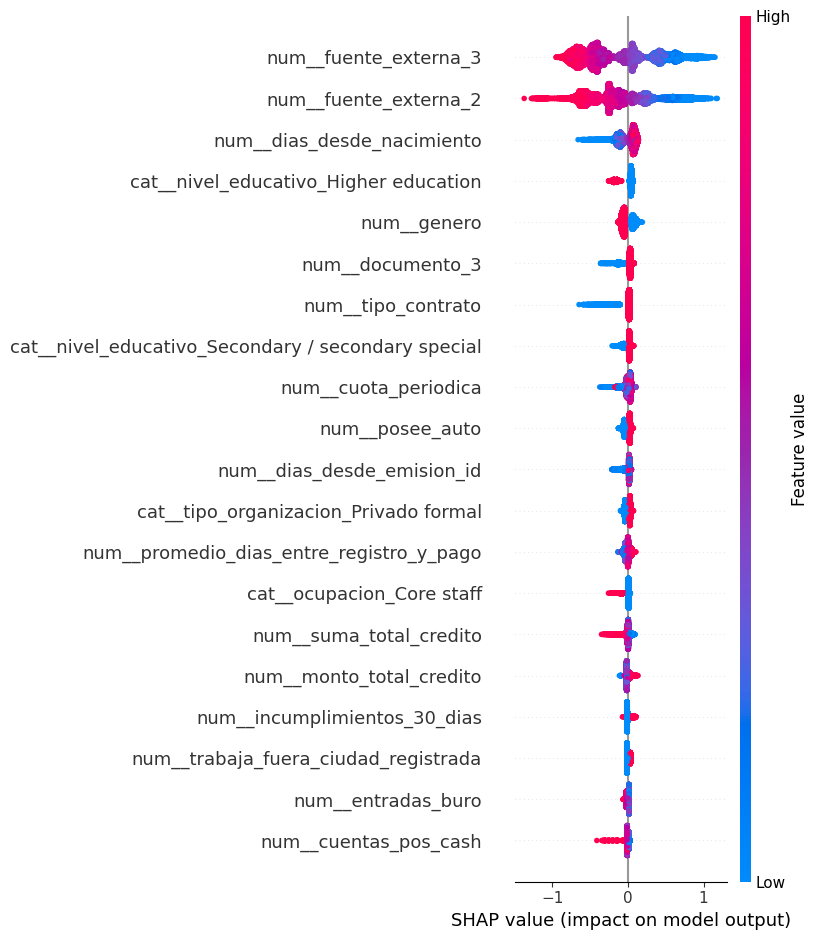

In [24]:
# 1) Preprocesar X_test
X_test_proc = best_xgb.named_steps["preproc"].transform(X_test)
feature_names = best_xgb.named_steps["preproc"].get_feature_names_out()

# 2) SHAP con TreeExplainer
explainer = shap.TreeExplainer(best_xgb.named_steps["clf"].get_booster())
shap_vals = explainer.shap_values(X_test_proc)

# 3) Gráfico resumen
shap.summary_plot(
    shap_vals,
    features=X_test_proc,
    feature_names=feature_names,
    max_display=20
)
